We switched to the LeakyRelu activation function instead of tanh, to observe possible theoretical advantages of it. However, there is not much of a difference.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define the dataset class
class YelpDataset(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [2]:
# Load each part of the dataset
data_parts = []
for i in range(1, 6):
    part_data = torch.load(f'./YELP-Rating/prep2_yelp_data_part_{i}.pt')
    data_parts.append(part_data)

In [3]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
full_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
labels = full_dataset.tensors[-1].numpy()

# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)

# Get the indices for the subset
subset_indices, _ = next(sss.split(torch.zeros(len(labels)), labels))

# Create a Subset of the original dataset using the subset indices
subset_dataset = Subset(full_dataset, subset_indices)

# Convert the Subset to a TensorDataset
subset_tensors = [tensor[subset_indices] for tensor in subset_dataset.dataset.tensors]
del full_dataset
full_dataset = TensorDataset(*subset_tensors)

In [5]:
# Load each part of the dataset
data_parts = []
for i in range(1, 6):
    part_data = torch.load(f'./YELP-Rating/test_prep2_yelp_data_part_{i}.pt')
    data_parts.append(part_data)

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
test_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [7]:
labels = test_dataset.tensors[-1].numpy()

# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)

# Get the indices for the subset
subset_indices, _ = next(sss.split(torch.zeros(len(labels)), labels))

# Create a Subset using the selected indices
subset_dataset = Subset(test_dataset, subset_indices)
# Convert the Subset to a TensorDataset
subset_tensors = [tensor[subset_indices] for tensor in subset_dataset.dataset.tensors]
del test_dataset
test_dataset = TensorDataset(*subset_tensors)

In [8]:
del data_parts

In [9]:
#subset_indices = range(500)  # Example indices for the subset

#full_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

In [10]:
import torch
from sklearn.model_selection import train_test_split


# Use train_test_split to split the dataset into training, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = (len(full_dataset) - train_size)

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [13]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Define the model architecture for regression
class BERTRegression(torch.nn.Module):
    def __init__(self):
        super(BERTRegression, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier1 = torch.nn.Linear(768, 256)
        self.classifier2 = torch.nn.Linear(256, 64)
        self.classifier3 = torch.nn.Linear(64, 1)
        self.activate = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        x1 = self.classifier1(pooler)
        x1_a = self.activate(x1)
        x1_drop = self.dropout(x1_a)
        x2 = self.classifier2(x1_drop)
        x2_a = self.activate(x2)
        x2_drop = self.dropout(x2_a)
        x3 = self.classifier3(x2_drop)
        out = self.sigmoid(x3)
        return out

model = BERTRegression()
criterion = nn.MSELoss()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
bert_params_rest = []
classifier_params = []

for name, param in model.named_parameters():
    if 'classifier' in name:
        classifier_params.append(param)
    elif 'bert.encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= num_bert_layers - 6:
            bert_params_last_6.append(param)
        else:
            param.requires_grad = False  # Freeze the previous layers
    else:
        bert_params_rest.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BERTRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device).float()  # Convert labels to float for regression
        labels = labels / 4
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
        loss = criterion(outputs, labels)  # Use the regression loss function
        total_train_loss += loss.item()
        
        # Calculate accuracy
        predictions = torch.round(outputs * 4) / 4  # Round the scaled predictions to the nearest quarter
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device).float()  # Convert labels to float for regression
            labels = labels / 4
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
            
            loss = criterion(outputs, labels)  # Use the regression loss function
            total_val_loss += loss.item()
            
            # Calculate accuracy
            predictions = torch.round(outputs * 4) / 4  # Round the scaled predictions to the nearest quarter
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    
    print(f'Training Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}')
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

In [ ]:
outs1()

In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc='Testing')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []
all_raw_predictions = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device).float()  # Convert labels to float for regression
        labels = labels / 4
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze()
        
        loss = criterion(outputs, labels)  # Use the regression loss function
        total_test_loss += loss.item()
        
        # Calculate accuracy
        predictions = torch.round(outputs * 4) / 4  # Round the scaled predictions to the nearest quarter
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_raw_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [25]:
outs2()

Average Testing Loss: 0.0253, Average Testing Accuracy: 0.6180


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0253, Testing Accuracy=0.618]  


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_12_8.pth')

In [26]:
outs1()

Epoch 1/4
Training Loss: 0.02111507493400709, Training Accuracy: 0.6463572990705303
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 2/4
Training Loss: 0.021097260101623487, Training Accuracy: 0.6490226899945325
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 3/4
Training Loss: 0.02101718099225677, Training Accuracy: 0.6454346637506835
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863
Epoch 4/4
Training Loss: 0.02104165478206727, Training Accuracy: 0.6470919901585566
Validation Loss: 0.02495637881642609, Validation Accuracy: 0.6357230392156863


In [19]:
outs2()

Average Testing Loss: 0.0253, Average Testing Accuracy: 0.6180


Testing: 100%|##########| 157/157 [01:10<00:00,  2.22it/s, Testing Loss=0.0253, Testing Accuracy=0.618]  


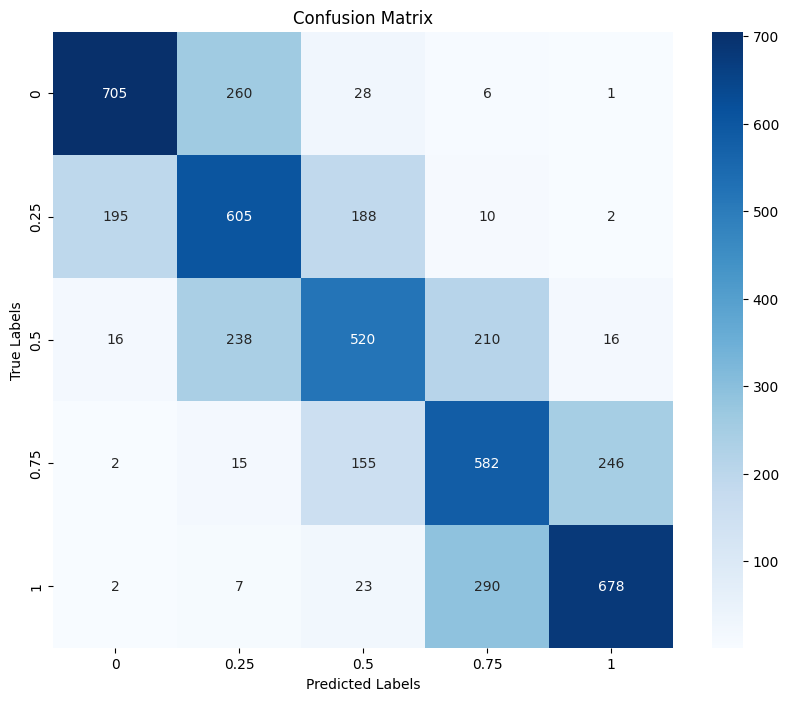

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Original labels and predictions
# all_labels and all_predictions should be defined elsewhere in your code

# Define the mapping
mapping = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}

# Function to map values to integers
def map_to_int(values, mapping):
    return np.array([mapping[v] for v in values])

# Map the labels and predictions
all_labels_mapped = map_to_int(all_labels, mapping)
all_predictions_mapped = map_to_int(all_predictions, mapping)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_mapped, all_predictions_mapped)

# Define class names for the heatmap
class_names = ['0', '0.25', '0.5', '0.75', '1']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np
from sklearn.metrics import accuracy_score

# Function to calculate accuracy for given thresholds
def calculate_accuracy(predictions, labels, thresholds):
    class_preds = np.digitize(predictions, thresholds)
    return accuracy_score(labels, class_preds)

# Convert back to original scale
labels = np.array(all_labels) * 4

# Define the objective function for optimization
def objective(thresholds):
    thresholds = np.sort(thresholds)  # Ensure thresholds are sorted
    return -calculate_accuracy(all_raw_predictions, labels, thresholds)  # We minimize, so negate accuracy

# Define bounds for the thresholds (three thresholds between 0 and 1)
bounds = [(0, 1), (0, 1), (0, 1), (0,1)]

class TqdmProgress:
    def __init__(self, max_iter):
        self.progress_bar = tqdm(total=max_iter, desc="Optimization Progress", position=0, leave=True)
        self.iteration = 0

    def __call__(self, xk, convergence):
        self.iteration += 1
        self.progress_bar.update(1)

    def close(self):
        self.progress_bar.close()

# Initialize the progress bar
progress = TqdmProgress(50000)

# Perform differential evolution to find the optimal thresholds
result = differential_evolution(
    objective, 
    bounds, 
    maxiter=50000,      
    popsize=500,          
    mutation=(0.5, 1),     
    recombination=0.5,     
    callback=progress       
)

# Close the progress bar
progress.close()
# Get the best thresholds and accuracy
best_thresholds = np.sort(result.x)
best_accuracy = -result.fun

print(f'Best Accuracy: {best_accuracy:.4f} with thresholds: {best_thresholds}')